# Example Brick Building

## Building a Random Projection Brick

Random projections can be effective feature extractors, and it serves as a pretty straightforward brick building example. 

First, some imports:

In [26]:
import numpy as np
np.random.seed(0)
import networkx as nx
import fugu
from fugu import Scaffold, Brick
from fugu.bricks import Vector_Input
from fugu.backends import snn_Backend
from fugu.scaffold import ChannelSpec, PortSpec, PortData, PortUtil

def plot_spike_raster(scaffold, results):
    import matplotlib.pyplot as plot
    num_elements=scaffold.graph.number_of_nodes()
    print('Number of neurons: ', num_elements)
    results.plot.scatter(x='time', y='neuron_number', title="Spike Raster")
    plot.show()
    
def plot_scaffold_graph(scaffold):
    edge_weights = [scaffold.graph.edges[v]['weight'] for v in scaffold.graph.edges()]
    nx.draw_networkx(scaffold.graph, 
                 with_labels = False, 
                 pos = nx.spring_layout(scaffold.graph),
                 edge_color = edge_weights,
                 node_size = 100)

All bricks should inherit from the `Brick` class.  Bricks that are listed as input bricks should instead inherit from `InputBrick`, which is beyond the scope of this tutorial.  The construction of most brick types is similar; constructing a brick that takes input coding "current" (see below) is a bit different and is beyond the scope of this tutorial.


The `Brick` class provides the framework for the scaffold to build a neural graph. Subclasses of `Brick` should provide the actual code that will generate the nodes and edges on a graph.  The graph construction should take place within the `build` method.  Let's look at the definition of the parent class `Brick`.

```python 
class Brick(ABC):
    def __init__(self):
        self.name = "Empty Brick"
        self.supported_codings = []

    def build2(self, graph, inputs: dict[str, PortData] = {}):
        pass

```

The first line `class Brick(ABC)` defines the abstract class of `Brick`.  Brick objects inherit from `ABC` which just means that `Brick` is an abstract class that cannot be instantiated on its own; only subclasses may be instantiated.

The ``__init__`` method contains standard instantiation code.  All bricks are expected to have a member property `self.name` that is unique to the brick.  The uniqueness needs to be determined by the scaffold, not by the brick.

The property `self.is_built` is a boolean that is True if the brick has been built (added to the graph).

The property `self.supported_codings` is a list of input codings (strings) that the brick supports.  Since you have the full use of python when you are defining your brick, you can support multiple coding types completely transparent to the user.  A full list of coding types can be found at `fugu.input_coding_types`.

The method `build2` will be called by the scaffold when the graph is to be built.  Arguments are:
- graph: The neuron graph object that we are building onto.
- inputs: A *dict* of input ports. Each *PortData* object describes the structure of one port, along with lists of concrete neuron IDs.

Each brick is responsible for throwing the appropriate errors/warnings if the inputs are not compatible with the brick.



The first line `class Brick(ABC)` defines the abstract class of `Brick`.  Brick objects inherit from `ABC` which just means that `Brick` is an abstract class that cannot be instantiated on its own; only subclasses may be instantiated.

The ``__init__`` method contains standard instantiation code.  All bricks are expected to have a member property `self.name` that is unique to the brick.  The uniqueness needs to be determined by the scaffold, not by the brick.

The property `self.is_built` is a boolean that is True if the brick has been built (added to the graph).

The property `self.supported_codings` is a list of input codings (strings) that the brick supports.  Since you have the full use of python when you are defining your brick, you can support multiple coding types completely transparent to the user.  A full list of coding types can be found at `fugu.input_coding_types`.

The method `build` will be called by the scaffold when the graph is to be built.  Arguments are:
- graph: The graph object that we are building onto.
- metadata: A dictionary of shapes and parameters. This will likely be removed in future implementations, so don't rely on it.
- control_nodes: A *dict* of *lists* of nodes that transmit a control information.  The most common is `control_nodes['complete']` which carries a list of 'finished' spikes from input bricks.  If your brick has one input, then this will be a list of a single node.  The only other currently used key is `control_nodes['begin']` which is used for temporally coded bricks (and outside the scope of this tutorial)
- input_lists:  A *list of lists* of nodes that correspond to input neurons. The outermost list contains a list of neurons, one for each input on the scaffold.  
- input_codings: A *list* of input coding types. The list contains one coding type per input on the scaffold.

Each brick is responsible for throwing the appropriate errors/warnings if the inputs are not compatible with the brick.

In [27]:
class RandomProjection(Brick):
    def __init__(self, 
                 name=None, 
                 output_size = 10,
                 connection_sparsity = 0.1,
                 ):
        super().__init__()
        self.output_size = output_size
        self.connection_sparsity = connection_sparsity
        
        #The brick hasn't been built yet.
        self.is_built = False
        #We just store the name passed at construction.
        self.name = name
        #For this example, we'll let any input coding work even though the answer might not make sense.
        self.supported_codings = fugu.input_coding_types
    # This method describes the input ports that any RandomProjection brick expects.
    # This includes the actual data values, as well as a signal indicating when the
    # source of input is ready for us to procss the data. Since we execute in a single
    # cycle, this signal is simply passed on to the next brick (see build2() later).
    @classmethod
    def input_ports(cls) -> dict[str, PortSpec]:
        port = PortSpec(name='input', minimum=1, maximum=1)  # Must be exactly 1 port, no more, no less.
        port.channels['data']     = ChannelSpec(name='data')
        port.channels['complete'] = ChannelSpec(name='complete')
        return {port.name: port}

    # This method describes the output port that any RandomProjection brick provides.
    # This includes the data and the 'complete' signal that we pass on.
    @classmethod
    def output_ports(cls) -> dict[str, PortSpec]:
        port = PortSpec(name='output')
        port.channels['data']     = ChannelSpec(name='data', coding=['Raster'])
        port.channels['complete'] = ChannelSpec(name='complete')
        return {port.name: port}

    # This method does the actual network construction. It reads the input ports, wires up
    # some neurons, and provides their identities via the output port.
    def build2(self, graph, inputs: dict[str, PortData] = {}):
        """
        Build RandomProjection brick.
        Raises:
            ValueError: If != 1 inputs.  Only 1 inputs is supported.  Error if unsupported mode.
        """
        # Expect two inputs
        if len(inputs) != 1:
            raise ValueError('Only one input supported.')

        # Set up convenience variables for accessing our working ports.
        input1 = inputs['input']  # Unpack the input ports.
        output_ports_dictionary = PortUtil.make_ports_from_specs(RandomProjection.output_ports())  # Create our output port(s).
        output_port = output_ports_dictionary['output']  # Unpack the only actual output port.
        output_data = output_port.channels['data']  # Unpack the data channel where our main result goes.

        # Keep the same coding as input 0 for the output
        # This is an arbitrary decision at this point.
        # Generally, your brick will impart some coding, but that isn't the case here.
        output_data.spec.coding = input1.channels['data'].spec.coding

        # Build the computational graph.
        # This is the heart of the brick.
        input_neurons = input1.channels['data'].neurons
        for postsynaptic_neuron_idx in range(self.output_size):
            # Generate a name for the new neuron, which also happens to be an output neuron.
            projection_neuron = self.generate_neuron_name(str(postsynaptic_neuron_idx))
            output_data.neurons.append(projection_neuron)
            # Create the neuron.
            graph.add_node(projection_neuron,
                           index=0,
                           threshold=1.0,
                           decay=1.0,
                           p=1.0,
                           potential=0.0)
            #Connect based on random draw:
            for presynaptic_neuron in input_neurons:
                if np.random.rand() < self.connection_sparsity: #random draw
                    graph.add_edge(presynaptic_neuron, 
                                   projection_neuron,
                                   weight=0.5,  #You probably want to use a "real" weight, but we'll just use 0.5
                                   delay=1)

        # Hook up the signals.
        # We just forward the incoming signal with one cycle of delay.
        complete_node_name = self.generate_neuron_name('complete')
        output_port.channels['complete'].neurons = [complete_node_name]
        graph.add_node(complete_node_name,
                       index=-1,
                       threshold=0.0,
                       decay=0.0,
                       p=1.0,
                       potential=0.0)
        graph.add_edge(input1.channels['complete'].neurons[0],
                       complete_node_name,
                       weight=1.0,
                       delay=1)

        self.is_built = True
        return output_ports_dictionary


## Building a Testing Scaffold

We'll now create some dummy data and a simple scaffold to test our new brick!

In [28]:
num_input_neurons = 100
simtime = 20
random_spikes = np.random.binomial(1, 0.2, size=(num_input_neurons, simtime)) #20% of our inputs neurons randomly spike

vi_brick = Vector_Input(random_spikes, coding='Raster', name='Input0',time_dimension=True)
rp_brick = RandomProjection(name='RP', output_size = 100, connection_sparsity = 0.05)
scaffold = Scaffold()
scaffold.add_brick(vi_brick,)
scaffold.add_brick(rp_brick, output=True)
scaffold.connect(vi_brick, rp_brick)
scaffold.lay_bricks()
scaffold.summary()

Scaffold is built: True
-------------------------------------------------------
List of Bricks:


Brick No.: 0
Brick Tag: Input0-14
Brick Name: Input0
{'tag': 'Input0-14', 'name': 'Input0', 'brick': <fugu.bricks.input_bricks.Vector_Input object at 0x173ec6d70>, 'layer': 'input', 'ports': {'output': PortData(spec=PortSpec(name='output', description='', index=0, minimum=1, maximum=1, channels={'data': ChannelSpec(name='data', description='', coding='Raster', shape=(100,), required=True), 'begin': ChannelSpec(name='begin', description='', coding=[], shape=None, required=True), 'complete': ChannelSpec(name='complete', description='', coding=[], shape=None, required=True)}), channels={'data': ChannelData(spec=ChannelSpec(name='data', description='', coding='Raster', shape=(100,), required=True), neurons=['Input0-14:(0,)', 'Input0-14:(1,)', 'Input0-14:(2,)', 'Input0-14:(3,)', 'Input0-14:(4,)', 'Input0-14:(5,)', 'Input0-14:(6,)', 'Input0-14:(7,)', 'Input0-14:(8,)', 'Input0-14:(9,)', 'Input0-1

## Plotting and Running
We can also plot our scaffold.graph and then run it on a simulator backend.

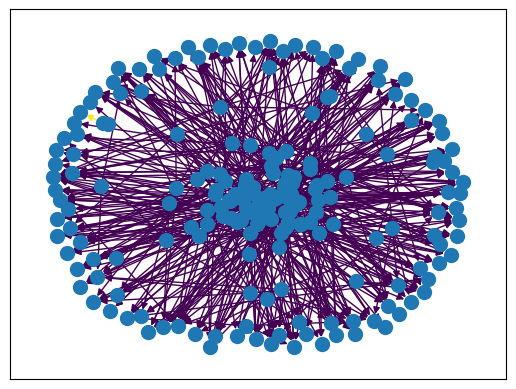

In [29]:
plot_scaffold_graph(scaffold)

In [31]:
backend = snn_Backend()
backend_args = {}
backend.compile(scaffold, backend_args)
output_ports_dictionary = backend.run(simtime)
print(output_ports_dictionary)

     time  neuron_number
0     1.0          106.0
1     1.0          114.0
2     1.0          129.0
3     1.0          133.0
4     1.0          138.0
..    ...            ...
206  19.0          159.0
207  19.0          160.0
208  19.0          175.0
209  19.0          190.0
210  19.0          195.0

[211 rows x 2 columns]


Number of neurons:  203


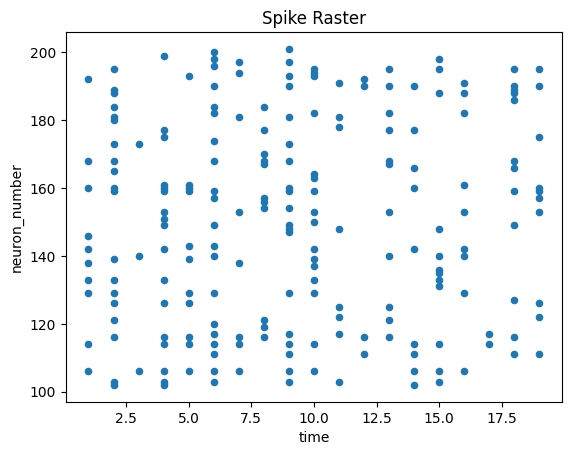

In [32]:
plot_spike_raster(scaffold, output_ports_dictionary)

## Trying a new initalization

Because we used parameters for our random projection, it's pretty easy to go ahead and modify those.

We'll try using slightly higher connection sparsity.

In practice, we could've allowed for much more functionality, such as:
- Loading a weight matrix
- Drawing weights from a distribution
- Having variable delays
- Structured connections from the input brick

In [33]:
vi_brick = Vector_Input(random_spikes, coding='Raster', name='Input0',time_dimension=True)
rp_brick = RandomProjection(name='RP', output_size = 100, connection_sparsity = 0.1)
scaffold = Scaffold()
scaffold.add_brick(vi_brick )
scaffold.add_brick(rp_brick, output=True)
scaffold.connect(vi_brick, rp_brick)
scaffold.lay_bricks()
backend.compile(scaffold, backend_args)
output_ports_dictionary = backend.run(simtime)

Number of neurons:  203


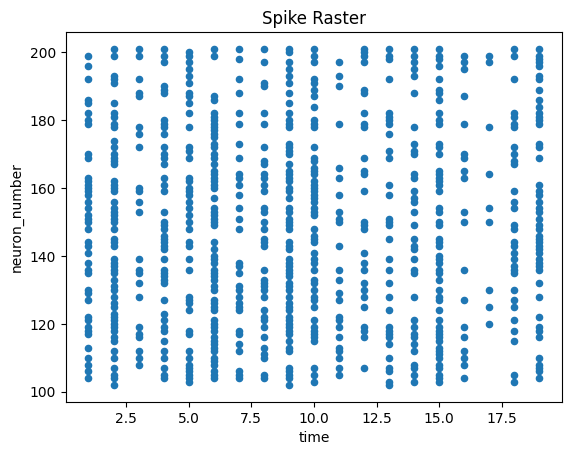

In [34]:
plot_spike_raster(scaffold, output_ports_dictionary)